# ATRX trans effect histograms


This notebook analyzes the trans effect of ATRX mutation for all proteins.

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import cptac
import cptac.utils as al

In [2]:
brain = cptac.Gbm()

In [3]:
def add_to_all_significant_comparisons(df, cancer, interacting, all_sig_comp):
    expanded = df
    expanded['Gene'] = gene
    expanded['Cancer_Type'] = cancer
    expanded['Interacting_Protein'] = interacting
    
    updated_all_comparisons = pd.concat([all_sig_comp, expanded], sort=False)
    
    return updated_all_comparisons

In [4]:
def add_significance_col(results_df, bonferroni_cutoff):
    results_df = results_df.dropna(axis=0)
    print(bonferroni_cutoff)
    for row_index, row in results_df.iterrows():
        pval = row['P_Value']
        if float(pval) <= bonferroni_cutoff:
            results_df['Significant'] = True
        else: 
            results_df['Significant'] = False
        continue
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests = None, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        if total_tests == None:
            number_of_comparisons = len(comparison_columns)
        else:
            number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        #all_comparisons_sig_col = add_significance_col(all_comparisons_df, bonferroni_cutoff)
        return all_comparisons_df
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


### Specify Gene

In [5]:
gene = "ATRX"

# Transcriptomics: All Proteins

In [7]:
t_omics = "transcriptomics"

try:
    print("\nGene: ", gene)

    #Use all proteins

    #Create dataframe in order to do comparisons with wrap_ttest
    protdf = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=t_omics)
    protdf = brain.reduce_multiindex(protdf, flatten=True)
    protdf = protdf[protdf.Sample_Status == 'Tumor'] # drop Normal samples
    
    #Create the binary valued column needed to do the comparison
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    col_list = list(protdf.columns)
    num_comparisons = len(col_list)
    col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    transcrpt_all_comparisons = wrap_ttest_return_all(protdf, 'Label', col_list)

    #all_comparisons = add_to_all_significant_comparisons(wrap_results, "Gbm", False, all_comparisons)
    print("Number of comparisons:", num_comparisons)
    t_bonferroni_cutoff = .05 / num_comparisons
    print("Bonferroni cutoff = ", t_bonferroni_cutoff)

except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  ATRX


Doing t-test comparisons

Number of comparisons: 60484
Bonferroni cutoff =  8.266649031148734e-07


Transcriptomics: Print Significant Comparisons

In [9]:
transcrpt_all_comparisons = transcrpt_all_comparisons.dropna(axis=0)
transcrpt_sig_comparisons = transcrpt_all_comparisons.loc[transcrpt_all_comparisons['P_Value'] <= t_bonferroni_cutoff]
print("Number of significant comparisons for Transcriptomics: ", len(transcrpt_sig_comparisons))
transcrpt_sig_comparisons.head()

Number of significant comparisons for Transcriptomics:  33


,Comparison,P_Value
3,EXOSC1_transcriptomics_ENSG00000171311.11,1.059106e-07
1249,AC005237.4_transcriptomics_ENSG00000225521.1,4.760715e-08
2148,AC010095.7_transcriptomics_ENSG00000235644.1,6.443425e-07
4007,AC093585.6_transcriptomics_ENSG00000229996.1,1.130568e-07
4608,AGAP4_transcriptomics_ENSG00000188234.12,4.749609e-07


Transcriptomics: Histogram for all proteins

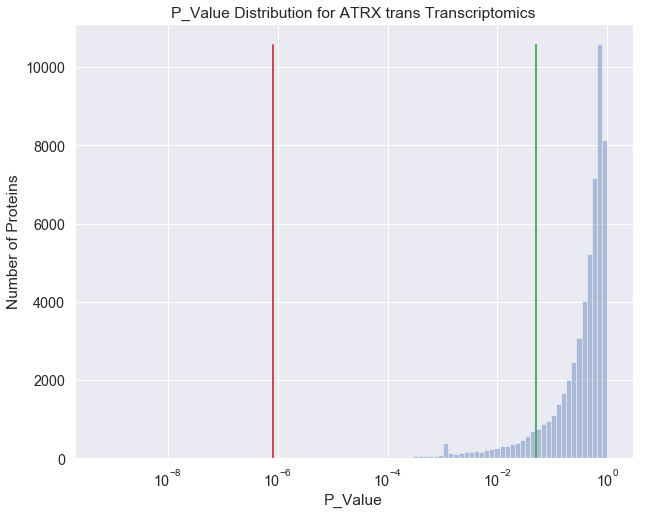

In [16]:
# Create series of p-values for Histogram
transcrpt_pval_series = transcrpt_all_comparisons['P_Value']

# Histogram LOG
t_bonferroni_cutoff = 0.05/num_comparisons
#print("Bonferroni cutoff: ", bonferroni_cutoff)

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
LogMin, LogMax = np.log10(transcrpt_pval_series.min()), np.log10(transcrpt_pval_series.max())
newBins = np.logspace(LogMin, LogMax, 100) # change bin number here
histogram = sns.distplot(transcrpt_pval_series, bins = newBins, kde=False) # bins 100 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Transcriptomics")
histogram.set(ylabel = 'Number of Proteins')
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(t_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Zoom in (only shows bonferroni cutoff)

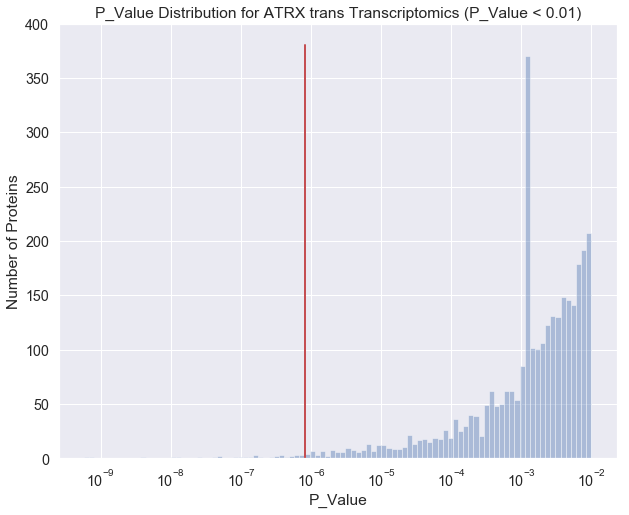

In [30]:
# Select p-values within range 0 - end_value 
t_end_value = 0.01
transcrpt_zoomed = transcrpt_pval_series.loc[transcrpt_pval_series <= t_end_value]

# Histogram LOGGED
t_bonferroni_cutoff = 0.05/num_comparisons
#print("Bonferroni cutoff: ", bonferroni_cutoff)

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
LogMin, LogMax = np.log10(transcrpt_zoomed.min()),np.log10(transcrpt_zoomed.max())
newBins = np.logspace(LogMin, LogMax, 100) # change this number for more or less bins
histogram = sns.distplot(transcrpt_zoomed, bins = newBins, kde=False)

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Transcriptomics (P_Value < " + str(t_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.ylim([0.0,400]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(t_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

# Proteomics: All Proteins

In [31]:
p_omics = "proteomics"

try:
    print("\nGene: ", gene)

    #Use all proteins

    #Create dataframe in order to do comparisons with wrap_ttest
    protdf = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=p_omics)
    protdf = brain.reduce_multiindex(protdf, flatten=True)
    protdf = protdf[protdf.Sample_Status == 'Tumor'] # drop Normal samples
    
    #Create the binary valued column needed to do the comparison
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    col_list = list(protdf.columns)
    num_comparisons = len(col_list)
    col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    prot_all_comparisons = wrap_ttest_return_all(protdf, 'Label', col_list)

    #all_comparisons = add_to_all_significant_comparisons(wrap_results, "Gbm", False, all_comparisons)
    print("Number of comparisons:", num_comparisons)
    p_bonferroni_cutoff = .05 / num_comparisons
    print("Bonferroni cutoff = ", p_bonferroni_cutoff)

except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  ATRX


Doing t-test comparisons

Number of comparisons: 11142
Bonferroni cutoff =  4.487524681385748e-06


Print Significant Comparisons

In [33]:
prot_all_comparisons = prot_all_comparisons.dropna(axis=0)
prot_sig_comparisons = prot_all_comparisons.loc[prot_all_comparisons['P_Value'] <= p_bonferroni_cutoff]
print("Number of significant Proteomics comparisons: ", len(prot_sig_comparisons))
prot_sig_comparisons.head()

Number of significant Proteomics comparisons:  2


,Comparison,P_Value
1642,ATRX_proteomics,3.530374e-09
9158,SUPV3L1_proteomics,1.495206e-06


Proteomics Histograms 

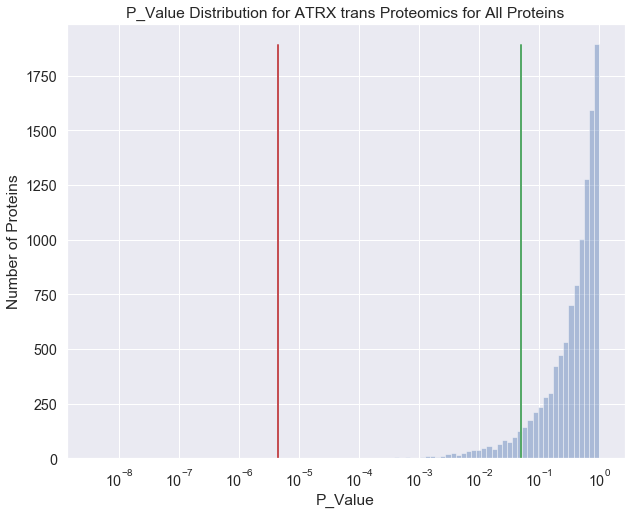

In [34]:
# Create series of p-values for Histogram
prot_pval_series = prot_all_comparisons['P_Value']

# Histogram LOG
p_bonferroni_cutoff = 0.05/num_comparisons
#print("Bonferroni cutoff: ", bonferroni_cutoff)

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
p_log_min, p_log_max = np.log10(prot_pval_series.min()), np.log10(prot_pval_series.max())
prot_bins = np.logspace(p_log_min, p_log_max, 100) # change bin number here
histogram = sns.distplot(prot_pval_series, bins = prot_bins, kde=False) # bins 100 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Proteomics for All Proteins")
histogram.set(ylabel = 'Number of Proteins')
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(p_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Proteomics zoomed in 

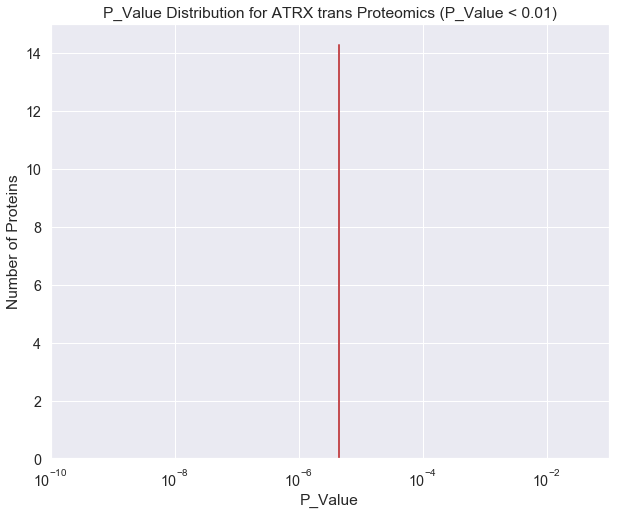

In [54]:
# Select p-values within range 0 - end_value 
p_end_value = 0.01
prot_zoomed = prot_pval_series.loc[prot_pval_series <= p_end_value]

# Histogram LOGGED
p_bonferroni_cutoff = 0.05/num_comparisons
#print("Bonferroni cutoff: ", bonferroni_cutoff)

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
zoomed_log_min, zoomed_log_max = np.log10(prot_zoomed.min()),np.log10(prot_zoomed.max())
prot_bins_zoomed = np.logspace(zoomed_log_min, zoomed_log_min, 10) # change this number for more or less bins
histogram = sns.distplot(prot_zoomed, bins = prot_bins_zoomed, kde=False)

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Proteomics (P_Value < " + str(p_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-11,10e-2])
plt.ylim([0.0,15]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(p_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()


In [ ]:
#FIX ABOVE